In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

print("done")

done


In [2]:
import import_func as imp
# import tags_work as tgs
# import desc_vis as vis
# import classifier_func as cls
import classifier_help as clh

def output_plot(outfile):
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(outfile, dpi=100, bbox_inches='tight')

In [3]:
full_filename = "../data/by_article_fulltext_020920.jl"

full_df = imp.init_df(full_filename, "full", categories="all")

full_df = full_df.drop(
    [
        "date",
        "time",
        "date_seq",
        "column1",
        "column2",
        "one_time",
        "bio",
    ],
    axis=1,
)


print("done")

categories = [
    "advice",
    "job market",
    "academic",
    "postdoc",
    "graduate",
    "workplace diversity",
    "midcareer",
    "non-disciplinary",
    "life and career balance",
    "industry",
    "career profiles",
    "government",
    "undergraduate",
    "working life",
    "early career",
    "career-related policy"
        ]

formal_labels = {}
        
new_categories = []
for cat in categories:
    cat_new = cat.replace(" ", "_").replace("-", "_")
    cat = cat[0].upper() + cat[1:]
    formal_labels[cat_new] = cat
    new_categories.append(cat_new)
categories = new_categories

plots = ["modals","first","second","hedges","boosters"]

word_type_labels = {
    "modals":"Modal verbs",
    "first":"First person pronouns",
    "second":"Second person pronouns",
    "hedges":"Hedges",
    "boosters":"Boosters"
    }

# print(categories)

done


In [4]:
perm_first = pd.read_csv("../data/bargraph_data/first_sig_test.csv")
perm_second = pd.read_csv("../data/bargraph_data/second_sig_test.csv")
perm_modal = pd.read_csv("../data/bargraph_data/modal_sig_test.csv")
perm_hedges = pd.read_csv("../data/bargraph_data/hedges_sig_test.csv")
perm_boosters = pd.read_csv("../data/bargraph_data/boosters_sig_test.csv")

sig_tests = {
"modals":perm_modal,
"first":perm_first,
"second":perm_second,
"hedges":perm_hedges,
"boosters":perm_boosters
}

perm_first.head(3)

,Unnamed: 0,tags,pval,test_statistic,tag_median
0,1,academic,0.00006,-0.001174,0.000000
1,2,advice,0.00005,0.000838,0.002012
2,3,career_profiles,0.92068,0.000053,0.001227


In [5]:

def tag_med_process(full_df, categories, word_type):
    cat_medians = []

    for cat in categories:
        cat_df = full_df[full_df[cat] == "yes"]

        if word_type == "first" or word_type == "second":
            counts_df = clh.pronouns(cat_df)
            # if word_type == "first":
                # col_name = "first"
            # else:
                # col_name = "second"
        elif word_type == "modals":
            counts_df = clh.modals(cat_df)
            # col_name = "modals"
        elif word_type == "hedges" or word_type == "boosters":
            counts_df = clh.hedges(cat_df, hedges=word_type)
        else:
            print("not working")

        counts_df["frac"] = counts_df[word_type]/counts_df["wc"]

        cat_med = np.median(counts_df.frac)
        cat_medians.append(cat_med)

    overall = pd.DataFrame({"category":categories,"median":cat_medians})
    return(overall)

def overall_comparison(full_df, word_type):
    if word_type == "first" or word_type == "second":
        counts_df = clh.pronouns(full_df)
        # if word_type == "first":
            # col_name = "first"
        # else:
            # col_name = "second"
    elif word_type == "modals":
        counts_df = clh.modals(full_df)
        # col_name = "modals"
    elif word_type == "hedges" or word_type == "boosters":
        counts_df = clh.hedges(full_df, hedges=word_type)


    counts_df["frac"] = counts_df[word_type]/counts_df["wc"]

    all_overall_first = np.median(counts_df["frac"])
    print(word_type, all_overall_first)
    return(all_overall_first)

def get_significance(sig_df, item, categories):
    p_thresh = []
    for cat in categories:
        # print(cat)
        # print(sig_df.get_value(sig_df.loc[sig_df["tags"] == cat].index[0],"pval"))
        sig = sig_df.get_value(sig_df.loc[sig_df["tags"] == cat].index[0],"pval")
        if sig < 0.001:
            p = "low"
        # elif sig < 0.01:
        #     p = "mod"
        else:
            p = "not"
        # print(p)
        p_thresh.append(p)
    return(p_thresh)

def position(item):
    j=1
    if item =="modals":
        i=0
    elif item == "first" or item == "second":
        i=1
        if item == "first":
            j=0
    else:
        i=2
        if item == "boosters":
            j=0
    return(i,j)

modals
first
second
hedges
boosters


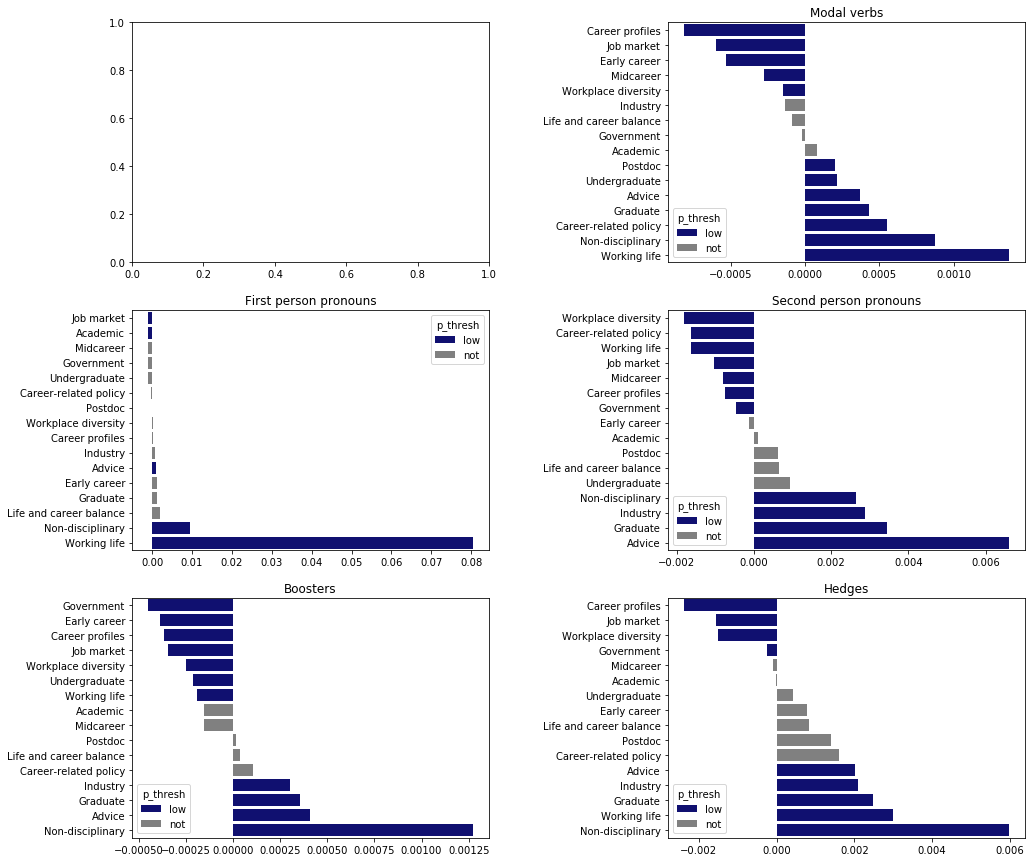

In [13]:
fig, axs = plt.subplots(3,2)
# fig.suptitle('Vertically stacked subplots')
# fig.figure(figsize=(12, 8))
fig.set_figheight(15)
fig.set_figwidth(16)
fig.subplots_adjust(wspace = .5)

color_dict = dict({'low':'navy',
                  'mod':'lightblue',
                  'not': 'gray'
                  })

for item in plots:
# for item in ["modals"]:
    print(item)
    i,j = position(item)
    overall = tag_med_process(full_df=full_df, categories=categories, word_type=item)
    baseline = overall_comparison(full_df=full_df, word_type=item)

    overall["dif"] = overall["median"]-baseline
    overall = overall.sort_values(by="dif")

    # significance tests
    sig_df = sig_tests[item]
    temp_cats =  overall["category"]
    p_thresh = get_significance(sig_df = sig_df, item = item, categories = temp_cats)
    # print(p_thresh)
    overall["p_thresh"] = p_thresh

    overall["category"] = [formal_labels[cat] for cat in overall["category"]]
    sns.barplot(y = "category", x = "dif",
    hue = "p_thresh",
    palette = color_dict,
    dodge=False,
    # legend=False,
    ax=axs[i,j],
    data = overall)
    axs[i,j].set_title(word_type_labels[item])

for ax in axs.flat:
    ax.set_ylabel('')
    ax.set_xlabel('')
    
fig.savefig("../figs/comparisons_words_categories/subplot_barplot.pdf", dpi=100, bbox_inches='tight')
